# Midterm Project
by Chiara Di Bonaventura

## 1. Data and Preprocessing (5 pts)

The **dataset** *data_coronavirus.xlsx* contains tweets about Coronavirus written in Italian from *10th March* to *16th March 2020* as long as users' ids, names, political party, geolocation, number of followers, of total tweets and retweets which I downloaded thanks to Twitter API and then I cleaned. In particular, I removed any symbols, emoji, tags, links, etc. by using regular expressions but I kept the contents following the # symbols since I want to keep track of these trending words (plus, it might be interesting seeing if some people use more hashtags than others in the analysis). 

I shoudl point out that to retrieve information about users' political party, I searched among the followers of several political accounts on Twitter. However, people might follow more than one account, and these can even be very different parties! Hence, I added a "macro_party" column to the dataset representing the overall political affiliation for each user. For instance, people who follow 'FratellidItalia' and/or 'forza_italia' belong to the 'CentroDestra' affiliation whereas people who follow 'LegaSalvini' and 'pdnetwork' are put into the 'Indifferent' class. Other political affiliations are EstremaDestra (people following only CasaPoundItalia account on Twitter - although it has zero seats in the Parliament, I included it since I was curious in studying their kind of communication on social media and comparing them with other official political parties), Centro (i.e. only Movimento5Stelle followers) and CentroSinistra. 


For what regards the **pre-processing steps**, I chose to apply the stemming procedure. Since Italian is a very complex language, I considered necessary to reduce variation as much as possible. Moreover, my analysis focuses on the semantics - since I am interested in what people write given their characteristics - and thanks to the specificity of the topic, i.e. COVID-19, and the rationality behind tweets (write a small text that is quick to read) I can exploit stemming. Indeed, it is plausible to think that words sharing the same stem have also a very similar meaning, given that we are talking exclusively about Coronavirus and the length of the text cannot exceed 280 characters. 
However, to offset the downside of the stemming procedure - that is the loss of interpretability - I then replaced each stem with the most common word associated to it. Notice that to pre-process the data, I used an external file containing all the standard Italian stopwords, which I partly modified by adding and subtracting some words according to the goals and needs of my analysis. 

Here, are the codes I wrote to pre-process the data. Since I have already saved the result under the column 'stems2' in the *data_coronavirus.xlsx* file, I comment them. To be as clear as possible, I did not add the code I used to clean the tweets in this file since it was quite long, but I will attach it in the zip file under the name "cleaning_data". 

In [1]:
# LOAD LIBRARIES
import numpy as np
import pandas as pd
import re 
import it_core_news_sm
nlp = it_core_news_sm.load()
from collections import Counter
from gensim.models import LdaMulticore, TfidfModel, CoherenceModel, Doc2Vec
from gensim.models.doc2vec import FAST_VERSION, TaggedDocument
from gensim.corpora import Dictionary
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import colors
%matplotlib inline
import multiprocessing 
import nltk
from nltk.collocations import BigramCollocationFinder, BigramAssocMeasures
from nltk.corpus import stopwords
import seaborn as sns
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.metrics import silhouette_score
from sklearn.decomposition import NMF, TruncatedSVD
from sklearn.manifold import TSNE

In [5]:
df = pd.read_excel('data_coronavirus.xlsx', encoding='utf8')

In [6]:
stops = pd.read_csv('stopwords-it.txt', ' ')
stops = list(stops['stopwords'])

In [ ]:
"""
documents = list(df['tweet'].values)
tokens = [[token.text for token in nlp(sentence) if not token.text in stops] for sentence in documents]

from nltk import SnowballStemmer
stemmer = SnowballStemmer('italian')

tweets_stem = [[stemmer.stem(token) for token in tweets] for tweets in tokens]

from collections import defaultdict
stem_origins = defaultdict(lambda: defaultdict(int)) 

for sentence in tokens:
    for token in sentence:
        stem = stemmer.stem(token)
        stem_origins[stem][token.lower()] += 1
        
tweets_stem2 = [[sorted(stem_origins[token].items(), key=lambda item: item[1])[-1][0] for token in tweet] for tweet in tweets_stem]
df.loc[:, 'stems2'] = tweets_stem2
df.loc[:,'stems2'] = df.apply(lambda row: ' '.join(row.stems2), axis = 1)

"""

Here, are some statistics about number of documents, types and tokens before and after the pre-processing:

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41199 entries, 0 to 41198
Data columns (total 10 columns):
userid         41199 non-null int64
username       41199 non-null object
tweet          41199 non-null object
nretweets      41199 non-null int64
party          41199 non-null object
location       24013 non-null object
totaltweets    41199 non-null int64
followers      41199 non-null int64
macro_party    41199 non-null object
stems2         41186 non-null object
dtypes: int64(4), object(6)
memory usage: 3.1+ MB


The number of documents before and after the pre-processing steps is not the same. So, I need to remove the missing texts: 

In [8]:
df = df[df['stems2'].notnull()]

In [9]:
docs = df.tweet.tolist()
vocabulary = set()
token = []
for document in docs:
    tokens = document.split() 
    vocabulary = vocabulary.union(set(tokens))
    for i in tokens:
        token.append(i)

vocabulary = sorted(vocabulary)
print(f"Before pre-processing the data, there were {len(vocabulary)} unique words that accounted for {len(token)} tokens.")

Before pre-processing the data, there were 35944 unique words that accounted for 1048399 tokens.


In [10]:
docs = df.stems2.tolist()

In [11]:
vocabulary = set()
token = []
for document in docs:
    tokens = document.split()
    vocabulary = vocabulary.union(set(tokens))
    for i in tokens:
        token.append(i)

vocabulary = sorted(vocabulary)
print(f"After pre-processing the data, there are {len(vocabulary)} types that accounts for {len(token)} tokens.")

After pre-processing the data, there are 23276 types that accounts for 504399 tokens.


## 2. Analysis (15 pts)

In the following analysis, I focus on what people write - that reflets of course what they think - about the Coronavirus emergency. For instance, are they complaining because of the drastic (but inevitable) measures introduced by the Italian government? About the lack of protective devices such as masks, hand sanitizers? Or are they mainly expressing solidarity towards the victims and the doctors? Furthermore, I am interested in studying if users' tweets depend on their own political affiliation. Do people belonging to different political affiliations share the same thoughts about the current emergency? Are there significant differences among them in the topics discussed? 

### 2.1. Distributed Representations: Document embeddings

First of all, to answer these questions, I focus on document embeddings. This way, I can represent each tweet in a n-dimensional space and make comparisons among them. Since I know the political affiliation of each tweet, I use it as a label for the documents. Moreover, 50 dimensions seem to work well in this case, so I choose this value for the vector_size parameter. 

In [12]:
corpus = []
for row in df.iterrows(): 
    label = row[1].macro_party 
    text = row[1].stems2 
    corpus.append(TaggedDocument(text.split(), tags=[str(label)])) 

d2v_model = Doc2Vec(vector_size=50, 
                    window=7, 
                    hs=0,
                    sample=0.000001,
                    negative=5,
                    min_count=0.1,
                    workers=-1,
                    epochs=200,
                    dm=1,          
                    dbow_words=1)

d2v_model.build_vocab(corpus)
d2v_model.train(corpus, total_examples=d2v_model.corpus_count, epochs=d2v_model.epochs)

In [13]:
d2v_model.docvecs.doctags

{'CentroSinistra': Doctag(offset=0, word_count=155833, doc_count=13295),
 'CentroDestra': Doctag(offset=1, word_count=91292, doc_count=7285),
 'Indifferent': Doctag(offset=2, word_count=209866, doc_count=16864),
 'LegaSalvini': Doctag(offset=3, word_count=19808, doc_count=1577),
 'Centro': Doctag(offset=4, word_count=14073, doc_count=1156),
 'EstremaDestra': Doctag(offset=5, word_count=13527, doc_count=1009)}

In [14]:
d2v_model.docvecs.most_similar('CentroSinistra')

[('Centro', 0.1870497763156891),
 ('Indifferent', 0.04170946031808853),
 ('LegaSalvini', 0.0038374513387680054),
 ('CentroDestra', -0.005122251808643341),
 ('EstremaDestra', -0.04046059399843216)]

This result states that tweets about Coronavirus of people belonging to the CentroSinistra and Centro political affiliations are the most similar to each other, which can have a reason behind since these two affiliations are the ones supporting the actual Governo Conte II, born in September 2019 after the crisis of the first Governo Conte. A score near zero means that the documents are uncorrelated. Hence, we can conclude that tweets from the LegaSalvini group are almost uncorrelated to the CentroSinistra ones. On the other hand, we find that CentroDestra and EstremaDestra parties have a negative score, meaning that these two categories of tweets point in totally different directions.

Given these scores, I deepen the analysis into the CentroSinistra and Centro groups to find the most common words in their tweets. Furthermore, I look at the tweets belonging to the LegaSalvini political affiliation. 

In [24]:
d2v_model.wv.most_similar([d2v_model.docvecs['CentroSinistra']], topn=10)

[('americanhustle', 0.5490642189979553),
 ('settoridici', 0.5169416666030884),
 ('scriventi', 0.5149527788162231),
 ('brexit', 0.5073429346084595),
 ('politicagrazie', 0.4687829613685608),
 ('school', 0.4647654891014099),
 ('dipingiamo', 0.45014792680740356),
 ('meditazionecoviditalia', 0.4493359923362732),
 ('venetovalutiamo', 0.4469757676124573),
 ('serietà', 0.4460810422897339)]

When we see two words next to each other without white spaces, this means that it was an hashtag.

In [17]:
d2v_model.wv.most_similar([d2v_model.docvecs['Centro']], topn=5)

[('urlando', 0.5893775224685669),
 ('ascoltate', 0.5188639760017395),
 ('contrappasso', 0.48847246170043945),
 ('equivale', 0.48628517985343933),
 ('unipg', 0.47186386585235596)]

In [25]:
d2v_model.wv.most_similar([d2v_model.docvecs['LegaSalvini']], topn=5)

[('cea', 0.514510989189148),
 ('finiamola', 0.4999447166919708),
 ('coronacrisis', 0.47598588466644287),
 ('supplychain', 0.47559601068496704),
 ('sabaudia', 0.4633025527000427)]

### 2.2. Analysis of important terms

Now, I am going to look at the most important words. I start by looking at unigrams and then I consider also bigrams and trigrams. Later, in the visualization part, I will show the distribution of such words for the entire dataset. 

In [26]:
tfidf_vectorizer = TfidfVectorizer(analyzer='word',
                                   min_df=0.001, 
                                   max_df=0.70, 
                                   stop_words=stops, 
                                   sublinear_tf=True) 
vectorizer = CountVectorizer(analyzer='word',  min_df=0.001, max_df=0.7, stop_words=stops)

X = tfidf_vectorizer.fit_transform(docs)
X_2 = vectorizer.fit_transform(docs)

freq = pd.DataFrame(data={'word': tfidf_vectorizer.get_feature_names(), 
                        'tf': X_2.sum(axis=0).A1, 
                        'idf': tfidf_vectorizer.idf_,
                        'tfidf': X.sum(axis=0).A1
                       })

freq = freq.sort_values(['tfidf', 'tf', 'idf'], ascending=False)
freq.reset_index(inplace=True)
freq

,index,word,tf,idf,tfidf
0,888,italia,10278,2.562183,1516.387619
1,1398,restateacasa,6257,2.885061,1282.196947
2,871,iorestoacasa,5594,3.005406,1158.387469
3,256,casa,4611,3.251863,827.638294
4,987,marzo,3523,3.486437,759.273205
...,...,...,...,...,...
1899,593,eroina,53,7.636894,12.967842
1900,471,derek,46,7.775730,12.954769
1901,1559,sfottere,52,7.655586,12.510703
1902,582,enea,45,7.797237,12.427616


As we can see, the most important words - i.e. what people talk more about during this emergency - are mostly related to the quarantine and staying at home. In particular, the hashtags *#restateacasa* and *#iorestoacasa* are very popular.

In [27]:
tfidf_vectorizer_grams = TfidfVectorizer(analyzer='word', 
                                   ngram_range=(2,3),
                                   min_df=0.001, 
                                   max_df=0.70, 
                                   stop_words=stops, 
                                   sublinear_tf=True) 

vectorizer_grams = CountVectorizer(analyzer='word', ngram_range=(2,3), min_df=0.001, max_df=0.70, stop_words=stops)

X_grams = tfidf_vectorizer_grams.fit_transform(docs)
X_2_grams = vectorizer_grams.fit_transform(docs)

freq_grams = pd.DataFrame(data={'word': tfidf_vectorizer_grams.get_feature_names(), 
                        'tf': X_2_grams.sum(axis=0).A1, 
                        'idf': tfidf_vectorizer_grams.idf_,
                        'tfidf': X_grams.sum(axis=0).A1
                       })

freq_grams = freq_grams.sort_values(['tfidf', 'tf', 'idf'], ascending=False)
freq_grams.head(10)

,word,tf,idf,tfidf
1780,restateacasa iorestoacasa,1520,4.298755,443.672385
1771,restare casa,758,5.020580,384.131160
564,decreto curaitalia,635,5.170679,344.505241
1151,italia italia,439,5.573789,262.920298
1358,medici infermieri,514,5.381711,246.900916
2119,stare casa,376,5.701622,228.295520
2186,terapia intensiva,390,5.690984,216.597311
1108,iorestoacasa restateacasa,312,5.879675,202.732838
1640,posso farlo,672,5.114133,188.892143
1788,restateacasa restiamoacasa,234,6.166292,172.067681


As we can see, the most common n-grams among bigrams and trigrams are hashtags related to staying at home. Indeed, it is plausible to think that people who invite people to remain at home (=*restateacasa*) in their tweets are also the ones that stay at home in quarantine (*iorestoacasa*). 

Now, I look at the most common collocations in the tweets:

In [28]:
words = [word.lower() for document in docs for word in document.split() 
         if len(word) > 2 
         and word not in stops]

finder = BigramCollocationFinder.from_words(words)
bgm = BigramAssocMeasures()
score = bgm.mi_like
collocations = {'_'.join(bigram): pmi for bigram, pmi in finder.score_ngrams(score)} 
Counter(collocations).most_common(10)

[('leucemia_esco', 607.7979620924406),
 ('terapia_intensiva', 345.3437194355177),
 ('farlo_potete', 329.587560477368),
 ('potete_aspettare', 277.749693608109),
 ('istigazione_delinquere', 257.0153256704981),
 ('angelilli_esponente', 253.55374592833877),
 ('omicidio_doloso', 246.62132352941177),
 ('doloso_propongo', 242.1696750902527),
 ('esco_posso', 238.8693618350038),
 ('posso_farlo', 232.72277514735723)]

Although the first one has a very high MI score, it does not represent a collocation. As a matter of fact, its high score is due to the fact that there was a tweet about a young child with leukemia that got many feedbacks on the web during the period this dataset was downloaded. However, we can still find the word "esco" by itself in the tweets. For this reason, I cannot set a threshold above which I concatenate the words. So, I replace the ones that can be truly considered as collocations using regular expressions. These are *terapia_intensiva* and *giuseppe_conte* since it makes sense to consider them collocations.

In [29]:
df['stems2'] = df['stems2'].str.replace(r"(terapia)|(intensiva)",'terapia_intensiva', regex=True)
df['stems2'] = df['stems2'].str.replace(r"(giuseppe)|(conte)",'giuseppe_conte', regex=True)

### 2.3. Topic Models: compare LDA with matrix factorization

* **2.3.1. LDA** 

By looking at the data, I got an overview of what people talk more about. The general topics covered by the tweets are gratitude towards nurses, doctors and everyone who risks his/her life to take care of infected people, support or critiques about the decisions undertaken by the government, encouraging people to stay home, spreading news about the virus and updates...
Hence, I can get different numbers of possible topics: from only two macro topics showing support or not support up to more topics such as support, updates, criticizing the lack of masks or queues at the supermarket, feedbacks about the government's actions. 

Given my prior knowledge about these general topics, I restricted the number of possible topics to a subset of 2 up to 7 topics. Then, in order to choose the optimal number of topics I rely on the CV Score:

In [35]:
df['stems2'] = df.stems2.apply(str)
instances = df.stems2.apply(str.split)[:] 
dictionary = Dictionary(instances)
dictionary.filter_extremes(no_below=100, no_above=0.1)

ldacorpus = [dictionary.doc2bow(text) for text in instances]
tfidfmodel = TfidfModel(ldacorpus) 

model_corpus = tfidfmodel[ldacorpus]

model_list = []
dev_size = 10000
eval_size = 5000 

for num_topics in range(2, 8):
    model = LdaMulticore(corpus=model_corpus[:dev_size], id2word=dictionary, num_topics=num_topics)
    model_list.append(model)
    coherencemodel_cv = CoherenceModel(model=model, 
                                       texts=instances[dev_size:dev_size+eval_size], 
                                       dictionary=dictionary, 
                                       coherence='c_v')
    cv_score = coherencemodel_cv.get_coherence()    
    print(num_topics, cv_score)

2 0.3674456886461511
3 0.3969340351992194
4 0.3841818870603211
5 0.39702897859791947
6 0.3625403362776322
7 0.3588143392368818


Finally, I choose the value that maximizes the CV Score. 

In [36]:
num_topics = 5
num_passes = 15
chunk_size = len(model_corpus) * num_passes/200

model = LdaMulticore(model_corpus, 
                     num_topics=num_topics, 
                     id2word=dictionary, 
                     workers=min(10, multiprocessing.cpu_count()-1), 
                     passes=num_passes, 
                     chunksize=chunk_size, 
                     alpha=0.16, 
                     eta=0.0025, 
                     per_word_topics = False
                    )

topic_corpus = model[model_corpus]

In [37]:
topic_sep = re.compile(r"0\.[0-9]{3}\*") 
model_topics = [(topic_no, re.sub(topic_sep, '', model_topic).split(' + ')) for topic_no, model_topic in
                model.print_topics(num_topics=num_topics, num_words=5)]

descriptors = []
for i, m in model_topics:
    print(i+1, ", ".join(m[:5]))
    descriptors.append(", ".join(m[:2]).replace('"', ''))

1 "giuseppe_conte", "governodelcontagio", "vergogna", "salvini", "rispettiamo"
2 "italiazonarossa", "celafaremo", "uniti", "italialockdown", "solidarietà"
3 "flashmobsonoro", "contagi", "flashmob", "balcone", "canto"
4 "potete", "aspettare", "farlo", "posso", "esco"
5 "quarantena", "marzo", "aggiornamento", "andratuttobene", "omnibusla"


From the dataset, we can clearly identify five topics: 
1. people that talk about the decision undertaken by the Premier Conte and the government;
2. people who write about the state of emergency we live in and highlight the importance of solidarity in this period; 
3. another topic is the so-called flashmobsonoro, that has become the daily appointment for italians to sing all together from the balconies;
4. there are people who talk more about the importance of staying at home;
5. the fifth topic regards updates of the emergency as the words "aggiornamento" and "omnibusla" suggest (the latter is a news program on television).


* **2.3.2. Matrix Factorization for latent topics:** 

Another way to retrieve information about topics is looking at the lower-dimensional view of the terms, the matrix H in the NMF algorithm, that is obtained when applying matrix factorization to the sparse matrix X. I apply the NMF algorithm since I use discrete features. 

In [38]:
documents = df.stems2.apply(str).tolist()

In [39]:
k=5
nmf = NMF(n_components=k, init='nndsvd', random_state=0) 
W = nmf.fit_transform(X) 
H = nmf.components_

In [40]:
import numpy as np
def show_topics(A, vocabulary, topn=5):
    
    topic_words = ([[vocabulary[i] for i in np.argsort(t)[:-topn-1:-1]]
                    for t in A])
    
    return [', '.join(t) for t in topic_words]

terms = tfidf_vectorizer.get_feature_names()
sorted(show_topics(H, terms))

['andratuttobene, quarantena, iorestoacasa, omnibusla, restateacasa',
 'casa, restateacasa, rischia, regole, rispettiamo',
 'governodellavergogna, conte, governodelcontagio, vergogna, giuseppe',
 'italia, bella, uniti, italialockdown, emergenza',
 'leucemia, esco, farlo, aspettare, potete']

As we can see, different topics can be identified: 
1. invite people to stay positive but remain at home;
2. urge people to respect the rules;
3. feedbacks about the decisions undertaken by the government;
4. invite people to express solidarity and union in this situation of national emergency;
5. refers to a story that caused a lot of feebacks about a young child with leukemia who has not been out of his house for 12 months now and these kinds of tweets urge adults to try to do the same.

These topics partly overlap with the ones obtained with LDA. In particular, we can find in both of them the topics about staying at home and the government. However, in the matrix factorization case I miss to identify the topic about updates.

When comparing LDA with Matrix Factorization, we must take into account the fact that the results we get in the latter case are a by-product of the matrix factoriazion and they are not particularly designed with the structure of how language works. For these reasons, it might be preferable using topic models such as LDA that, unlike matrix factorization, allow us also for flexibility. Indeed, in topic models if we do not like an outcome, we can adjust it by changing the parameters, like the prior distribution for the topic or for the words. 

### 2.4. Clustering with doc embeddings

In the following analysis, I use clustering to see whether these tweets form larger groups or not. I suspect that there might be between 2 and 3 clusters representing people that support the actual government, people against the government Governo Conte II, and there might be a group of people that are indifferent. Alternatevely, there might be a number of clusters equal to the total number of different political affiliations, that is 6. For this reason, in order to choose the number of clusters, I look at the Silhoutte score. Here, I consider tweets as "indipendent", which means I create a 5-digit for each of them.

Since the dataset is too big for agglomerative clustering, I initialize the KMeans algorithm with the centroids derived from running the agglomerative clustering on a subset of the data. Plus, I do not apply dimensionality reduction before the clustering because I have a dense matrix with 50 dimensions. 

In [41]:
corpus = []
for docid, document in enumerate(docs):
    corpus.append(TaggedDocument(document.split(), tags=["{0:0>5}".format(docid)]))

d2v_model = Doc2Vec(vector_size=50, 
                    window=5, 
                    hs=0,
                    sample=0.000001,
                    negative=5,
                    min_count=0.1,
                    workers=-1,
                    epochs=200,
                    dm=0,          
                    dbow_words=1)

d2v_model.build_vocab(corpus)
d2v_model.train(corpus, total_examples=d2v_model.corpus_count, epochs=d2v_model.epochs)
X = d2v_model.docvecs.vectors_docs

In [42]:
sample = np.random.choice(len(X), replace=False, size=8000)
silhouettes = []

K = range(2, 7)

for c in K:
    agg_clustering = AgglomerativeClustering(n_clusters=c)

    agg_cluster_ids = agg_clustering.fit_predict(X[sample])
    agg_centroids = np.array([X[[i for i, v in enumerate(agg_cluster_ids) if v == k]].mean(axis=0) for k in range(c)])

    kmeans_clustering = KMeans(n_clusters=c, n_jobs=-1, init=agg_centroids)
    kmeans_ids = kmeans_clustering.fit_predict(X)
    score = silhouette_score(X[sample], agg_cluster_ids)
    silhouettes.append(score)
    print(c, score)

C:\Users\diboc\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: RuntimeWarning: Explicit initial center position passed: performing only one init in k-means instead of n_init=10
  return_n_iter=True)


2 0.0026331535


C:\Users\diboc\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: RuntimeWarning: Explicit initial center position passed: performing only one init in k-means instead of n_init=10
  return_n_iter=True)


3 -0.0010199128


C:\Users\diboc\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: RuntimeWarning: Explicit initial center position passed: performing only one init in k-means instead of n_init=10
  return_n_iter=True)


4 -0.0015091923


C:\Users\diboc\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: RuntimeWarning: Explicit initial center position passed: performing only one init in k-means instead of n_init=10
  return_n_iter=True)


5 -0.0019027641


C:\Users\diboc\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: RuntimeWarning: Explicit initial center position passed: performing only one init in k-means instead of n_init=10
  return_n_iter=True)


6 -0.0029716294


The silhouette score is maximized for k=2 clusters.

In [43]:
k=2
agg = AgglomerativeClustering(n_clusters=k)
agg_sample_ids = agg.fit_predict(X[sample])
centroids = np.array([X[sample][agg_sample_ids == c].mean(axis=0) for c in range(k)])

km = KMeans(n_clusters=k, 
            n_jobs=-1, 
            init=centroids)
km.fit(X)

C:\Users\diboc\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: RuntimeWarning: Explicit initial center position passed: performing only one init in k-means instead of n_init=10
  return_n_iter=True)


KMeans(algorithm='auto', copy_x=True,
       init=array([[ 6.0336879e-05,  2.3028253e-05, -4.6497904e-04, -1.6823111e-04,
        -2.3199442e-04,  1.0765673e-03,  6.0249097e-04,  6.6881708e-05,
         4.3390857e-04, -6.5050859e-05, -9.9543744e-05,  2.7587274e-04,
         7.3796691e-04, -4.7528745e-05, -1.7960969e-05,  2.6855129e-04,
         3.5670676e-04,  2.6003798e-04,  2.5167846e-04, -2.3402835e-04,
         3.2136406e-05...
         3.9547865e-04,  1.8503105e-04,  1.2416882e-04, -1.9995912e-04,
         4.1664264e-04, -9.4628842e-05,  3.6327234e-05,  3.0090104e-04,
         4.7013158e-04,  3.4542161e-05,  4.3848559e-04, -2.4187168e-04,
        -1.1043495e-04, -3.2193350e-04, -2.9844980e-04, -2.0872359e-04,
        -5.1492988e-04, -3.8887051e-04]], dtype=float32),
       max_iter=300, n_clusters=2, n_init=10, n_jobs=-1,
       precompute_distances='auto', random_state=None, tol=0.0001, verbose=0)

For each tweet, I obtained a label indicating its cluster. For instance, for the first 20 tweets: 

In [44]:
km.labels_[:20]

array([0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0, 1])

## 3. Visualization (10 pts)

In [45]:
sns.set_context('notebook')
def plot_vectors(vectors, title='Plot', labels=None, dimensions=3):
   
    fig = plt.figure(figsize=(10,10))
    df = pd.DataFrame(data={'x':vectors[:,0], 'y': vectors[:,1]})

    if labels is not None:
        df['label'] = labels
    else:
        df['label'] = [''] * len(df)

    cm = plt.get_cmap('nipy_spectral')
    n_labels = len(df.label.unique())
    label_colors = [cm(1. * i/n_labels) for i in range(n_labels)]
    cMap = colors.ListedColormap(label_colors)

    if dimensions == 3:
        df['z'] = vectors[:,2]
        ax = fig.add_subplot(111, projection='3d')
        frame1 = plt.gca() 
        frame1.axes.xaxis.set_ticklabels([])
        frame1.axes.yaxis.set_ticklabels([])
        frame1.axes.zaxis.set_ticklabels([])

        for l, label in enumerate(df.label.unique()):
            df2 = df[df.label == label]
            color_values = [label_colors[l]] * len(df2)
            ax.scatter(df2['x'], df2['y'], df2['z'], 
                       c=color_values, 
                       cmap=cMap, 
                       edgecolor=None, 
                       label=label, 
                       alpha=0.4, 
                       s=100)

    elif dimensions == 2:
        ax = fig.add_subplot(111)
        frame1 = plt.gca() 
        frame1.axes.xaxis.set_ticklabels([])
        frame1.axes.yaxis.set_ticklabels([])

        for l, label in enumerate(df.label.unique()):
            df2 = df[df.label == label]
            color_values = [label_colors[l]] * len(df2)
            ax.scatter(df2['x'], df2['y'], 
                       c=color_values, 
                       cmap=cMap, 
                       edgecolor=None, 
                       label=label, 
                       alpha=0.4, 
                       s=100)

    else:
        raise NotImplementedError()

    plt.title(title)
    plt.legend()
    plt.show()

Proceeding with the clustering analysis, I want to display the results. To do so, I reduce the dimensionality of X to 3 dimensions with SVD:

In [47]:
low_dim_svdX = TruncatedSVD(n_components=3)
low_dim_U = low_dim_svdX.fit_transform(X)

silhouettes = []
K = range(2, 7)

for c in K:
    agg_clustering = AgglomerativeClustering(n_clusters=c)

    agg_cluster_ids = agg_clustering.fit_predict(low_dim_U[sample])
    agg_centroids = np.array([low_dim_U[[i for i, v in enumerate(agg_cluster_ids) if v == k]].mean(axis=0) for k in range(c)])

    kmeans_clustering = KMeans(n_clusters=c, n_jobs=-1, init=agg_centroids)
    kmeans_ids = kmeans_clustering.fit_predict(low_dim_U)
    score = silhouette_score(low_dim_U[sample], agg_cluster_ids)
    silhouettes.append(score)
    print(c, score)

C:\Users\diboc\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: RuntimeWarning: Explicit initial center position passed: performing only one init in k-means instead of n_init=10
  return_n_iter=True)


2 0.16657291


C:\Users\diboc\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: RuntimeWarning: Explicit initial center position passed: performing only one init in k-means instead of n_init=10
  return_n_iter=True)


3 0.17617181


C:\Users\diboc\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: RuntimeWarning: Explicit initial center position passed: performing only one init in k-means instead of n_init=10
  return_n_iter=True)


4 0.17557697


C:\Users\diboc\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: RuntimeWarning: Explicit initial center position passed: performing only one init in k-means instead of n_init=10
  return_n_iter=True)


5 0.15123278


C:\Users\diboc\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: RuntimeWarning: Explicit initial center position passed: performing only one init in k-means instead of n_init=10
  return_n_iter=True)


6 0.14608167


C:\Users\diboc\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: RuntimeWarning: Explicit initial center position passed: performing only one init in k-means instead of n_init=10
  return_n_iter=True)


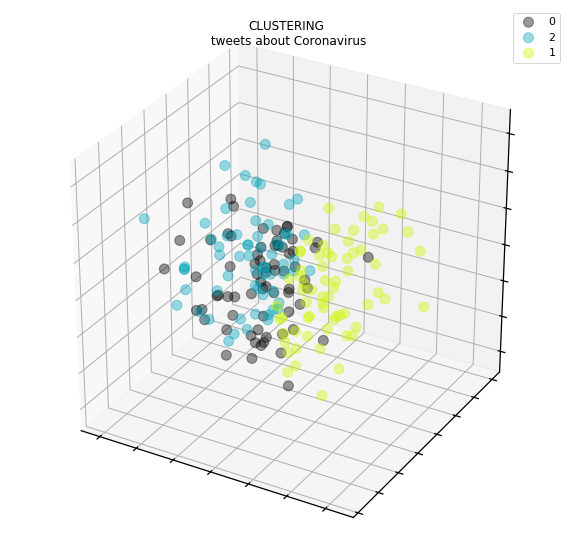

In [49]:
k=3
agg = AgglomerativeClustering(n_clusters=k)
agg_sample_ids = agg.fit_predict(low_dim_U[sample])
centroids = np.array([low_dim_U[sample][agg_sample_ids == c].mean(axis=0) for c in range(k)])

km = KMeans(n_clusters=k, 
            n_jobs=-1, 
            init=centroids)
km.fit(low_dim_U)

plot_sample = np.random.choice(len(low_dim_U), replace=False, size=200)
plot_vectors(low_dim_U[plot_sample], labels=km.labels_[plot_sample], dimensions=3, 
             title='CLUSTERING\n tweets about Coronavirus')

There seems to be a clear division among tweets, at least for the blue and yellow groups. For instance, these groups can represent the two main political classes that, respectevely, support the actual government and does not plus an indifferent class of people. Unfortunately, clustering does not allow us to go back to the original inputs. So, I cannot test this theory and there might be something else that differentiates these people.

In the following part, I apply matrix factorization to document embeddings and provide some plots.

In the plot below, I use SVD algorithm to reduce the dimensionality to 3 components in order to plot the doc embeddings in a 3D graph:

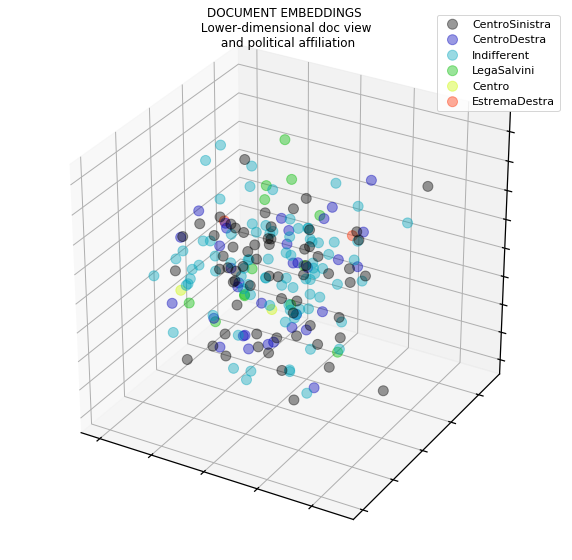

In [50]:
Z = X[:200]
categories = df.macro_party[:200]

low_dim_U = low_dim_svdX.fit_transform(Z)

plot_vectors(low_dim_U, title='DOCUMENT EMBEDDINGS \n Lower-dimensional doc view \n and political affiliation', 
             labels=categories, dimensions=3)

By comparing the plots above, it is clear that political affiliation is not a key factor in clustering people. Indeed, tweets of people belonging to different categories are well spread out in the graph. This leads us to conclude that there might be other factors to take into consideration that differentiate people. Since I collected other information about the users such as their number of followers and the number of retweets for each tweet, I can focus, for instance, on the status. 

In the following two graphs I use the t-SNE algorithm to plot doc embeddings. In the first, I reproduce another plot about tweet embeddings and their political affiliation. I played around with different values for the parameters of t-SNE and each plot returned the same conclusion, i.e. tweets seem to be similar to each other even though they belong to different political affiliations. 

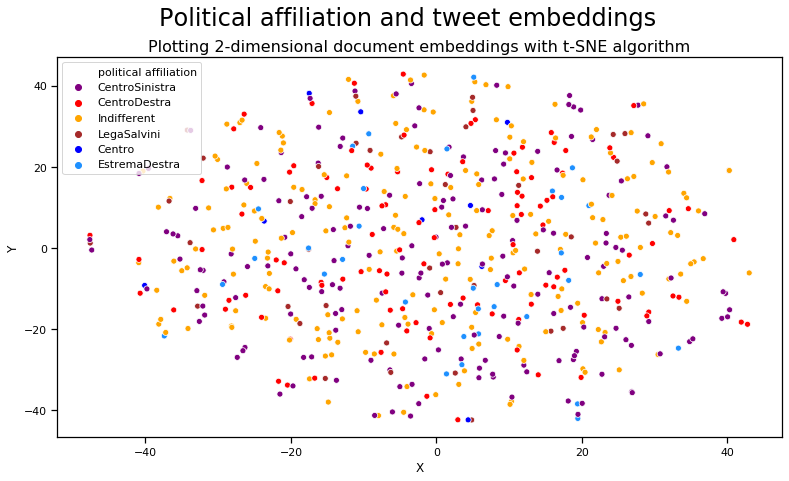

In [51]:
data_X = X[:600]
y = df.macro_party[:600]

tsne = TSNE(n_components=2, random_state=0, learning_rate=20.0, perplexity=10)

tsne_obj= tsne.fit_transform(data_X)
tsne_df = pd.DataFrame({'X':tsne_obj[:,0],
                        'Y':tsne_obj[:,1],
                        'political affiliation':y})

fig = plt.gcf()
fig.set_size_inches(13, 7)

plt.title('Plotting 2-dimensional document embeddings with t-SNE algorithm', fontsize=16)
plt.suptitle('Political affiliation and tweet embeddings', fontsize=24)

sns.scatterplot(x="X", y="Y", hue="political affiliation", palette=['purple','red','orange','brown','blue','dodgerblue'],
                legend='full', data=tsne_df);

Given this result, let's see if other characteristics could have an impact, such as number of followers of the user. 

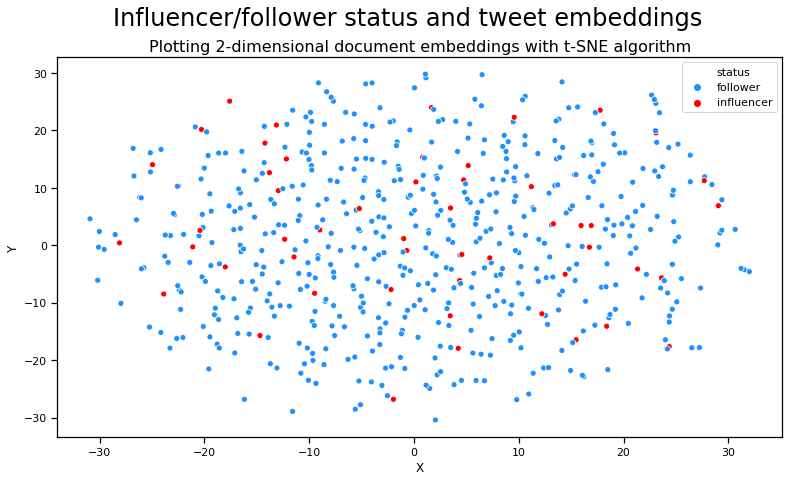

In [52]:
df.loc[df['followers']>=100000, 'status'] = 'influencer'
df.loc[df['followers']<100000, 'status'] = 'follower'

y = df.status[:600]
tsne = TSNE(n_components=2, random_state=0, learning_rate=40.0, perplexity=20)

tsne_obj= tsne.fit_transform(data_X)
tsne_df = pd.DataFrame({'X':tsne_obj[:,0],
                        'Y':tsne_obj[:,1],
                        'status':y})
fig = plt.gcf()
fig.set_size_inches(13, 7)
plt.title('Plotting 2-dimensional document embeddings with t-SNE algorithm', fontsize=16)
plt.suptitle('Influencer/follower status and tweet embeddings', fontsize=24)

sns.scatterplot(x="X", y="Y", hue="status", palette=['dodgerblue', 'red'],
                legend='full', data=tsne_df);

As we can see, neither the status is accountable for clustering tweets about Coronavirus. 

Now, I focus on what people write when talking about Coronavirus in Italy to see the most important words and topics either in general and given the political affiliations. 

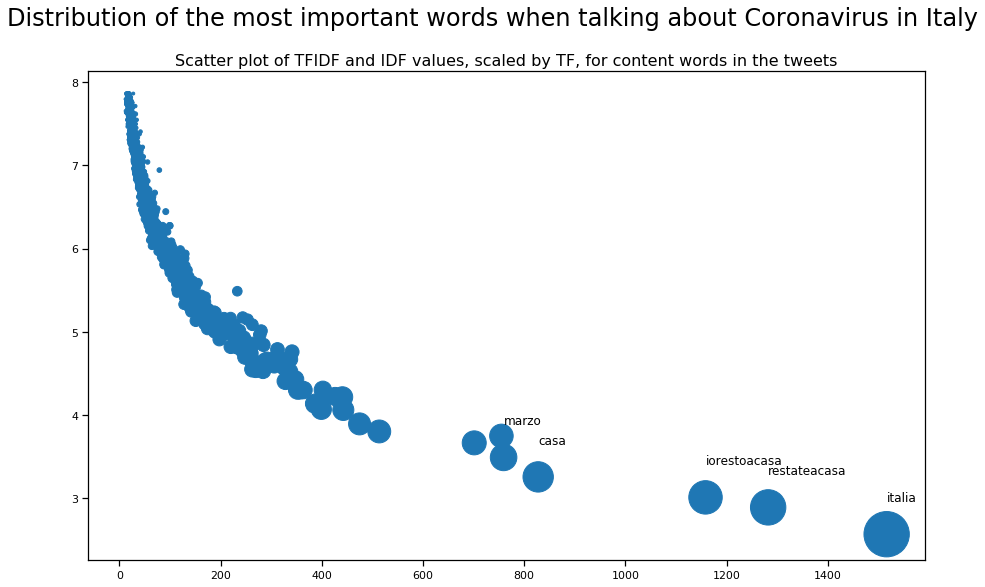

In [53]:
fig, ax = plt.subplots(figsize=(15,9))
labels = list(freq.word[:5])

ax.scatter(freq['tfidf'], freq['idf'],freq['tf']/5, cmap="Spectral")
for i, txt in enumerate(labels):
    ax.annotate(txt, (freq['tfidf'][i]+0.4, freq['idf'][i]+0.4), fontsize=12)
plt.suptitle('Distribution of the most important words when talking about Coronavirus in Italy', fontsize=24)
plt.title('Scatter plot of TFIDF and IDF values, scaled by TF, for content words in the tweets', fontsize=16)
plt.show()

Text(0.5, 1.0, 'LDA topic model')

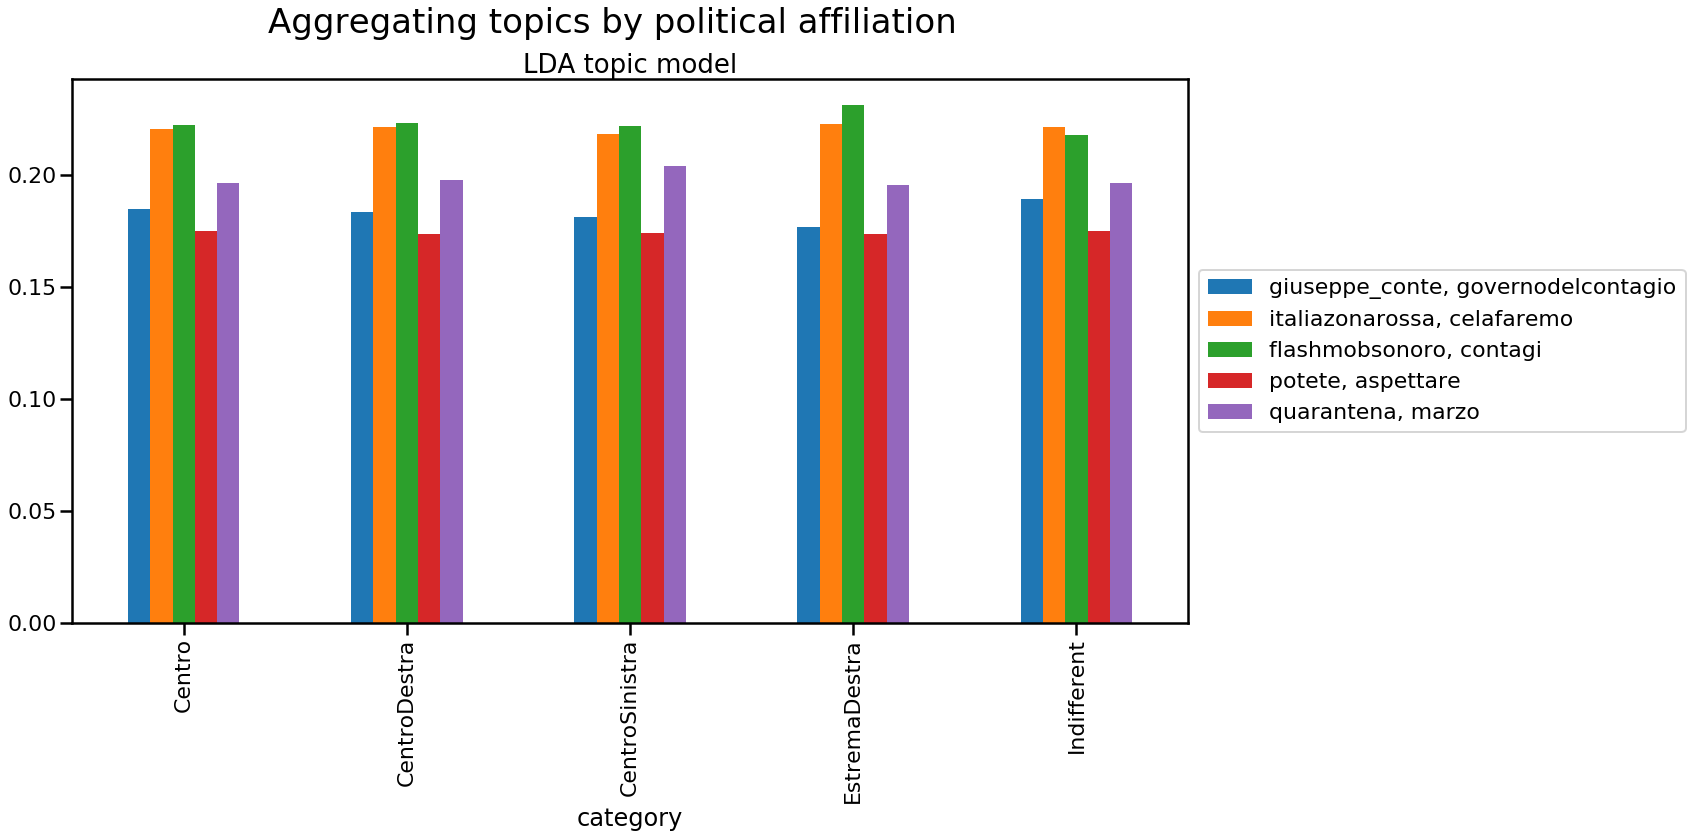

In [54]:
target_category = 'macro_party'
scores = [[t[1] for t in topic_corpus[entry]] for entry in range(len(instances))]
topic_distros = pd.DataFrame(data=scores, columns=descriptors)
topic_distros['category'] = df[target_category][:]

sns.set_context('poster') 

fig, ax = plt.subplots(figsize=(20, 10)) 

aggregate_by_category = topic_distros[topic_distros.category.isin('Indifferent Centro CentroDestra CentroSinistra EstremaDestra'.split())]
aggregate_by_category = aggregate_by_category.groupby(aggregate_by_category.category).mean()
aggregate_by_category[descriptors].plot.bar(ax=ax);

plt.legend(loc='center left', bbox_to_anchor=(1.0, 0.5));
plt.suptitle('Aggregating topics by political affiliation', fontsize=34)
plt.title('LDA topic model', fontsize=26)

Again, this result is coherent with the previous results. Since the analysis showed that the tweet embeddings were all near each other, I expected to be very little difference in the topics discussed by people belonging to different political affiliations. 

Answering the questions that led this project, in the situation of global emergency we live in, people tend to communicate very similar topics, regardless their political affiliation. The majority of these topics express solidarity and the importance of staying positive as well as staying home.